In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids, plot_res_gp, my_plot_convergence
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from sklearn.metrics import mean_squared_error
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.model_21_price_history_seq2seq_dyn_dec_ins import PriceHistorySeq2SeqDynDecIns
from gp_opt.price_history_23_gp_opt import PriceHistory23GpOpt
from os.path import isdir
from cost_functions.huber_loss import huber_loss

In [4]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [5]:
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 64
with_EOS = False

In [6]:
total_size = 57994
train_size = 46400
test_size = 11584

### Once generate data

In [7]:
data_folder = '../../../../Dropbox/data'


In [8]:
ph_data_path = '../data/price_history'

In [9]:
npz_full = ph_data_path + '/price_history_dp_60to30_57994.npz'
npz_train = ph_data_path + '/price_history_dp_60to30_57994_46400_train.npz'
npz_test = ph_data_path + '/price_history_dp_60to30_57994_11584_test.npz'

### Step 1 - collect data

In [10]:
# dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
# dp.inputs.shape, dp.targets.shape

In [11]:
# aa, bb = dp.next()
# aa.shape, bb.shape

### Step 2 - Build model

In [12]:
model = PriceHistorySeq2SeqDynDecIns(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [13]:
# graph = model.getGraph(batch_size=batch_size,
#                        num_units=num_units,
#                        input_len=input_len,
#                        target_len=target_len)

In [14]:
#show_graph(graph)

### Step 3 training the network

In [15]:
best_params = [500,
 tf.nn.tanh,
 0.0001,
 0.62488034788862112,
 0.001]

In [16]:
num_units, activation, lamda2, keep_prob_input, learning_rate = best_params

In [17]:
batch_size

64

In [18]:
def experiment():
    return model.run(npz_path=npz_train,
             npz_test = npz_test,
             epochs=100,
             batch_size = batch_size,
             num_units = num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = learning_rate,
             preds_gather_enabled=True,
             batch_norm_enabled = True,
             activation = activation,
             decoder_first_input = PriceHistorySeq2SeqDynDecIns.DECODER_FIRST_INPUT.ZEROS,
             keep_prob_input = keep_prob_input,
             lamda2 = lamda2,
            )

In [19]:
#%%time
dyn_stats, preds_dict, targets = get_or_run_nn(experiment, filename='024_seq2seq_60to30_002',
                                               nn_runs_folder= data_folder + '/nn_runs')

One epoch takes approximately 268 secs
If we want to let it run for ~8 hours = 8 * 3600 / 268 ~= 107 epochs
So let it run for 100 epochs and see how it behaves

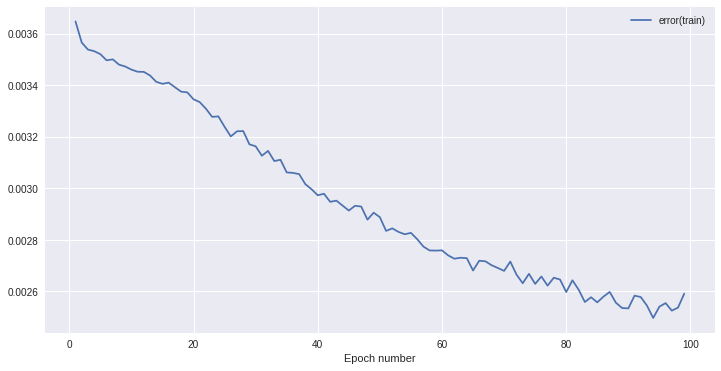

In [20]:
dyn_stats.plotStats()
plt.show()

In [21]:
data_len = len(targets)

In [22]:
mses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds_dict.values(), targets.values())):
    mses[ii] = mean_squared_error(pred, target)

In [23]:
np.mean(mses)

0.0064100403901840011

In [24]:
huber_losses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds_dict.values(), targets.values())):
    huber_losses[ii] = np.mean(huber_loss(pred, target))

In [25]:
np.mean(huber_losses)

0.0032050201950920005

In [26]:
targets_arr = np.array(targets.values())
targets_arr.shape

(11584, 30)

In [27]:
preds_arr = np.array(preds_dict.values())
preds_arr.shape

(11584, 30)

In [28]:
np.mean(huber_loss(y_true=targets_arr, y_pred=preds_arr))

0.003205020195092001

In [29]:
r2_scores = [r2_score(y_true=targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(targets))]

In [30]:
ind = np.argmin(r2_scores)
ind

8836

In [31]:
reals = targets[ind]
preds = preds_dict[ind]

In [32]:
r2_score(y_true=reals, y_pred=preds)

-2.1755069904281949e+31

In [33]:
#sns.tsplot(data=dp.inputs[ind].flatten())

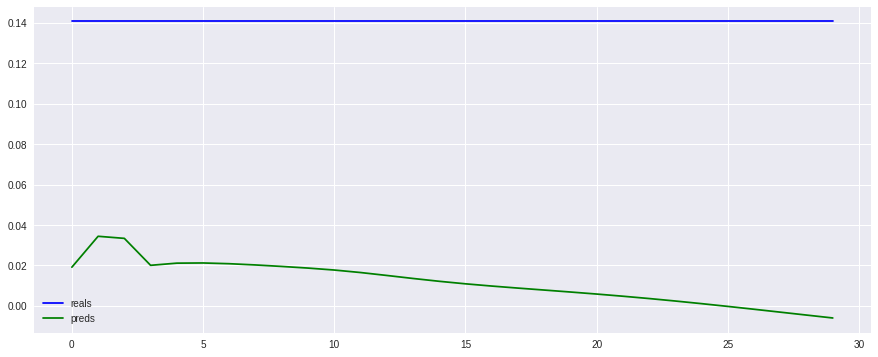

In [34]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [35]:
%%time
dtw_scores = [fastdtw(targets[ind], preds_dict[ind])[0]
             for ind in range(len(targets))]

CPU times: user 24.8 s, sys: 112 ms, total: 24.9 s
Wall time: 24.7 s


In [36]:
np.mean(dtw_scores)

1.1534351983616165

In [37]:
coint(preds, reals)

(-1.9885027565779438,
 0.53454911650336534,
 array([-4.31395736, -3.55493606, -3.19393252]))

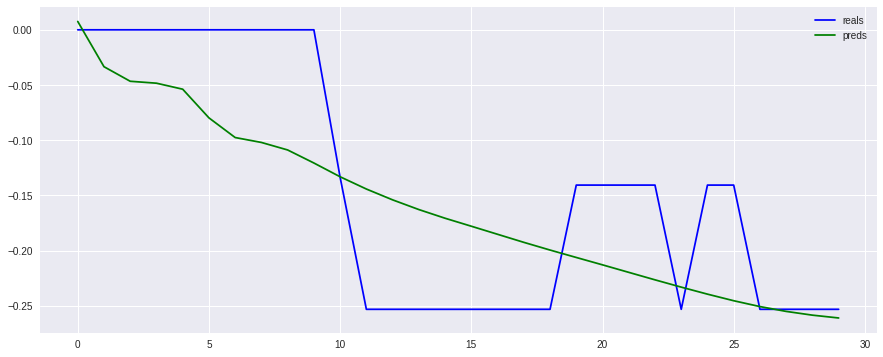

In [52]:
cur_ind = np.random.randint(len(targets))
reals = targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

### Conclusion
We have managed to make it work. We have done better in MSE and Huber Loss metrics but the DTW is still comparable with the baseline and a little above it. We need to add more information to the model in order to improve it